[16.10.20]
Frame-by-frame classification
=======================================================

* Having a collection of videos with pre-defined "true" categories and a pretrained classifier:
    1. extract each frame of each video;
    2. perform a classification of each individual frame;
    3. extract the **per-frame accuracies** for the true category.
* Frame extractor variants:
    * [decord](https://github.com/dmlc/decord) [implemented]:
        ```
        vr = decord.VideoReader()
        frame_id_list = range(start, stop, pace)
        video_frames = vr.get_batch(frame_id_list).asnumpy()
        ```
    * [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html) [TODO]
 

# Moments in Time videos

In [1]:
%%bash
unameOut="$(uname -s)"
case "${unameOut}" in
    Linux*)     machine=Linux;;
    Darwin*)    machine=Mac;;
    CYGWIN*)    machine=Cygwin;;
    MINGW*)     machine=MinGw;;
    *)          machine="UNKNOWN:${unameOut}"
esac

if [ ${machine} == 'Linux' ]
then
    pip install --upgrade decord
else
    echo "Install decord following the steps in https://github.com/dmlc/decord#mac-os"
fi

Clone the [frame-by-frame](https://github.com/CogNeuroUR/frame-by-frame) repo:

In [2]:
!git clone https://github.com/CogNeuroUR/frame-by-frame.git

Cloning into 'frame-by-frame'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 80 (delta 6), reused 49 (delta 3), pack-reused 25
Unpacking objects: 100% (80/80), done.


In [ ]:
# Imports
import os
from decord import VideoReader
from decord import cpu #, gpu
import decord
decord.bridge.set_bridge('native') # Seems to be the fastest option
#decord.bridge.set_bridge('torch') # or 'tensorflow', or 'mxnet'

from pathlib import Path

## Frame-by-frame classification

##### ResNet50-MiT (torch)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import functional as F

from PIL import Image
from os import listdir
from os.path import isfile, join

import numpy as np
from random import sample, randint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path_prefix = Path().parent.absolute() / 'frame-by-frame'

In [ ]:
resnet50 = models.resnet50(pretrained=False, progress=True, num_classes=339).to('cuda')

[Down]-load MiT-pretrained model:

In [ ]:
#!curl http://moments.csail.mit.edu/moments_models/resnet50_moments-fd0c4436.pth --output resnet50_moments-fd0c4436.pth
path_model = path_prefix / 'model_zoo/resnet50_moments-fd0c4436.pth'
resnet50_moments = resnet50
resnet50_moments.load_state_dict(torch.load('resnet50_moments-fd0c4436.pth'))
resnet50_moments.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transformation = transforms.Compose([
                                     transforms.ToPILImage(mode='RGB'), # required if the input image is a nd.array
                                     transforms.Resize(224), # To be changed to rescale to keep the aspect ration?
                                     transforms.CenterCrop((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
])

In [ ]:
#!curl https://raw.githubusercontent.com/zhoubolei/moments_models/master/category_momentsv1.txt --output category_momentsv1.txt
!!curl https://raw.githubusercontent.com/vrabiutz/my_images/master/category_momentsv1.txt --output category_momentsv1.txt
def load_categories():
    """Load categories."""
    with open(path_prefix / 'labels/category_momentsv1.txt') as f:
        return [line.rstrip() for line in f.readlines()]

# load categories
categories = load_categories()

###### Single video

In [ ]:
# Load video
print(os.getcwd())
video_fname = str(path_prefix / 'data/test/abseiling_k400.mp4')
vr = VideoReader(video_fname)#, ctx=cpu(0))
print('video frames:', len(vr))

/content
video frames: 250


torch.Size([3, 224, 224])


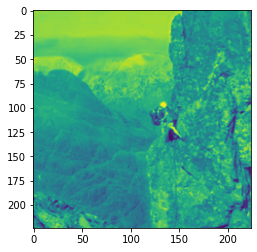

--Top Actions:
0.794 -> climbing
0.050 -> hiking
0.043 -> ascending
0.042 -> jumping
0.029 -> descending


In [ ]:
# Accuracy test
video_frames = vr.get_batch([i for i in range(len(vr))])
img = video_frames.asnumpy()[randint(0, len(vr))]

# Image transformation
t_img = transformation(img).to('cuda')
print(t_img.shape)

plt.imshow(t_img[0].cpu())
plt.show()

# Classification:
logit = resnet50_moments.forward(t_img.unsqueeze(0))
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

#print(img_url)
# output the prediction of action category
print('--Top Actions:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], categories[idx[i]]))

0


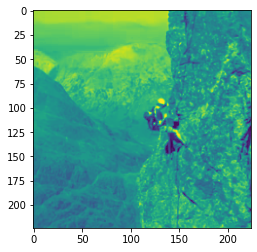

--Top Actions:
0.368 -> climbing
0.157 -> jumping
0.138 -> ascending
0.117 -> descending
0.053 -> hiking
20


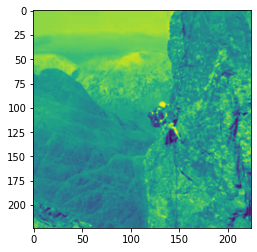

--Top Actions:
0.677 -> climbing
0.094 -> ascending
0.078 -> hiking
0.070 -> descending
0.033 -> jumping
40


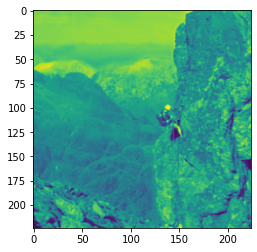

--Top Actions:
0.691 -> climbing
0.112 -> hiking
0.060 -> ascending
0.043 -> jumping
0.043 -> descending
60


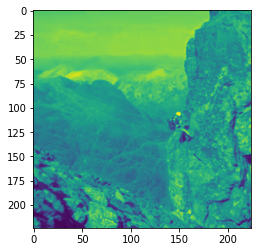

--Top Actions:
0.795 -> climbing
0.072 -> hiking
0.049 -> ascending
0.031 -> descending
0.018 -> jumping
80


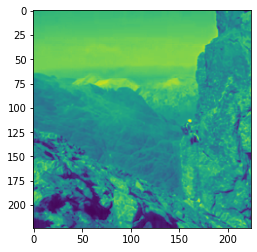

--Top Actions:
0.652 -> climbing
0.161 -> hiking
0.063 -> ascending
0.037 -> descending
0.026 -> jumping
100


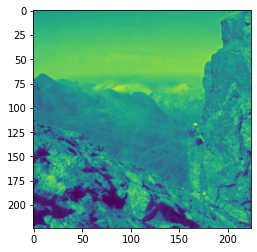

--Top Actions:
0.555 -> climbing
0.318 -> hiking
0.043 -> ascending
0.030 -> descending
0.013 -> jumping
120


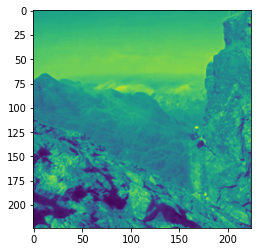

--Top Actions:
0.442 -> hiking
0.433 -> climbing
0.036 -> ascending
0.027 -> descending
0.016 -> bicycling
140


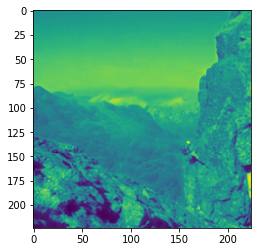

--Top Actions:
0.424 -> hiking
0.337 -> climbing
0.063 -> diving
0.056 -> jumping
0.038 -> ascending
160


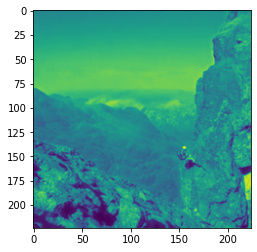

--Top Actions:
0.476 -> hiking
0.411 -> climbing
0.022 -> ascending
0.021 -> diving
0.019 -> jumping
180


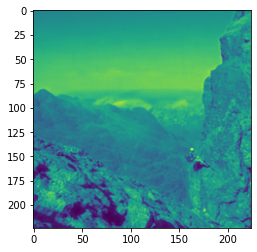

--Top Actions:
0.596 -> hiking
0.303 -> climbing
0.021 -> ascending
0.017 -> diving
0.014 -> descending
200


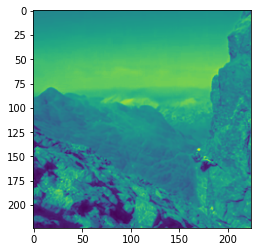

--Top Actions:
0.784 -> hiking
0.145 -> climbing
0.013 -> ascending
0.009 -> descending
0.007 -> jumping
220


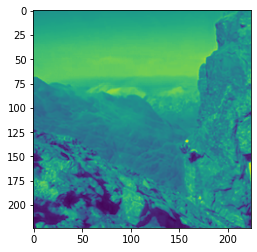

--Top Actions:
0.538 -> hiking
0.322 -> climbing
0.030 -> jumping
0.027 -> ascending
0.017 -> descending
240


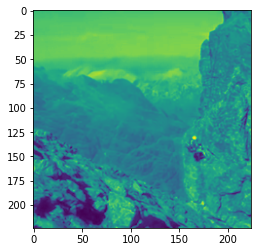

--Top Actions:
0.521 -> climbing
0.387 -> hiking
0.020 -> ascending
0.014 -> jumping
0.012 -> descending


In [ ]:
pred_accuracies = []
true_category = 'climbing'

for i in range(video_frames.shape[0]):
    frame = video_frames.asnumpy()[i]
    input = transformation(frame).to('cuda')
    
    # Classification:
    logit = resnet50_moments.forward(input.unsqueeze(0))
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)

    # At each 20th frame, make a plot and print the top 5 categories with
    # the corresponding accuracy
    if i % 20 == 0:
        print(i)
        plt.imshow(input[0].cpu())
        plt.show()
        print('--Top Actions:')
        for i in range(0, 5):
            print('{:.3f} -> {}'.format(probs[i], categories[idx[i]]))
        
    pred_accuracies.append(probs.cpu()[[i for i in range(len(categories)) if categories[idx[i]]==true_category]])

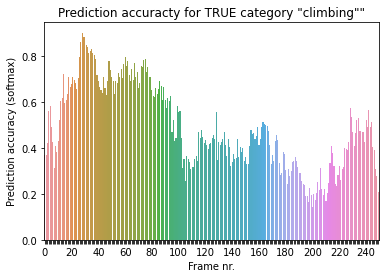

In [ ]:
ax = sns.barplot(data=pred_accuracies)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 20 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_title(f'Prediction accuracty for TRUE category \"{true_category}\""')
ax.set_xlabel('Frame nr.')
ax.set_ylabel('Prediction accuracy (softmax)')

plt.show()

###### Multi-video frame extraction

Go through each folder of the `MIT_sampleVideos_RAW` and
* Take the name of the category folder
* Iterate over the videos of that category AND extract the frame-by-frame accuracy

In [ ]:
# Collect the names of all video files and their path in the dataset
import os

path_prefix = '/content/drive/My Drive/MIT_sampleVideos_RAW/'
#path_prefix = 'MIT_sampleVideos_RAW/'
d_files_per_category = {}

# Iterate over categories in path_prefix
for root, dirs, files in os.walk(path_prefix, topdown=False):
    for name in dirs:
        category_path = os.path.join(root, name)
        category_name = category_path.split('/')[-1]
        print(category_name)

        # Iterate over files in cateogory_path
        d_files_per_category[category_name] = {}
        for root2, dirs2, videos  in os.walk(category_path, topdown=False):
            for video in videos:
                video_fname = os.path.join(root2, video)
                
                d_files_per_category[category_name][video] = video_fname


In [ ]:
import time
from torch.nn import functional as F

accuracies_per_category = {}
times_per_file = []

z = 1 # For verbose
# Iterate over categories in path_prefix
for category_name in list(d_files_per_category.keys()):
    print(f'{category_name} {z}/{len(list(d_files_per_category.keys()))}')
    z += 1
    # Iterate over files in cateogory_path
    accuracies_per_category[category_name] = {}
    for video in list(d_files_per_category[category_name]):
        #start_time = time.time()
        video_fname = d_files_per_category[category_name][video]
        
        print('\t', video)

        # Load video with Decord.VideoReader
        vr = VideoReader(video_fname, ctx=cpu(0))
        frame_id_list = range(0, len(vr), 1)
        video_frames = vr.get_batch(frame_id_list)

        pred_accuracies = []
        true_category = category_name
        #true_category = 'bathing'

        start_time = time.time()
        for i in range(video_frames.shape[0]):
            
            frame = video_frames.asnumpy()[i]
            input = transformation(frame).to('cuda')
            
            # Classification:
            logit = resnet50_moments.forward(input.unsqueeze(0))
            h_x = F.softmax(logit, 1).data.squeeze()
            probs, idx = h_x.sort(0, True)
            # Save accuracies
            #pred_accuracies.append(probs.numpy()[[i for i in range(len(categories)) if categories[idx[i]]==true_category]])
            pred_accuracies.append(probs.cpu().numpy()[[i for i in range(len(categories)) if categories[idx[i]]==category_name]])
        # Calculate avg duration per frame
        end_time = time.time()
        print('\tAvg duration per frame: %4.4f seconds.' % ((end_time - start_time)/(10*video_frames.shape[0])))
        
        accuracies_per_category[category_name][video] = pred_accuracies
        #accuracies_per_file.append(pred_accuracies)
        times_per_file.append((end_time - start_time)/10)
#accuracies_per_category.append(accuracies_per_file)

        


In [ ]:
# Save dictionary to pickle file
import pickle
dict_path = '/content/drive/My Drive/accuracies_per_category_ResNet50_MiTv1.pkl'
f = open(dict_path, 'wb')
pickle.dump(accuracies_per_category, f)
f.close()

In [ ]:
import pickle
dict_path = '/content/drive/My Drive/accuracies_per_category.pkl'
f = open(dict_path, 'rb')
accuracies_per_category = pickle.load(f)

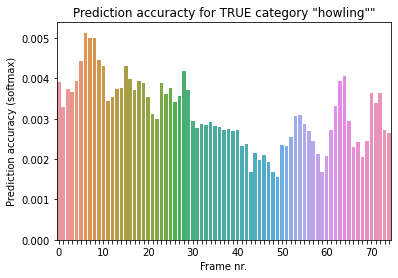

In [ ]:
import seaborn as sns
ax = sns.barplot(data=accuracies_per_category['breaking']['giphy-LirabC73gVe92_3.mp4'])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_title(f'Prediction accuracty for TRUE category \"{true_category}\""')
ax.set_xlabel('Frame nr.')
ax.set_ylabel('Prediction accuracy (softmax)')

plt.show()

##### I3D (Kinetics) (**TODO**)

In [ ]:
%%bash
pip install --upgrade pip
pip install --upgrade numpy
pip install --upgrade tensorflow tensorflow-gpu tensorflow-probability
pip install --upgrade dm-sonnet tqdm
#git clone https://github.com/deepmind/kinetics-i3d

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.3)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: tensorflow-probability in /usr/local/lib/python3.6/dist-packages (0.11.1)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
Requirement already up-to-date: dm-sonnet in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.50.1)


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.1 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
tensorflow-gpu 2.3.1 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

data

In [ ]:
import sonnet as snt
import tensorflow as tf

In [ ]:
print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))

TensorFlow version: 2.3.1
    Sonnet version: 2.0.0


In [ ]:
class MLP(snt.Module):

  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = snt.Flatten()
    self.hidden1 = snt.Linear(1024, name="hidden1")
    self.hidden2 = snt.Linear(1024, name="hidden2")
    self.logits = snt.Linear(10, name="logits")

  def __call__(self, images):
    output = self.flatten(images)
    output = tf.nn.relu(self.hidden1(output))
    output = tf.nn.relu(self.hidden2(output))
    output = self.logits(output)
    return output

In [ ]:
mlp = MLP()
mlp

MLP()

In [ ]:
%%bash
cd kinetics-i3d/
python i3d_test.py

2020-10-08 10:46:28.506469: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] I3dTest.testInitErrors
INFO:tensorflow:time(__main__.I3dTest.testInitErrors): 0.0s
I1008 10:46:30.851811 140175693281152 test_util.py:1973] time(__main__.I3dTest.testInitErrors): 0.0s
[  FAILED  ] I3dTest.testInitErrors
[ RUN      ] I3dTest.testModelShapesWithSqueeze
INFO:tensorflow:time(__main__.I3dTest.testModelShapesWithSqueeze): 0.0s
I1008 10:46:30.854610 140175693281152 test_util.py:1973] time(__main__.I3dTest.testModelShapesWithSqueeze): 0.0s
[  FAILED  ] I3dTest.testModelShapesWithSqueeze
[ RUN      ] I3dTest.testModelShapesWithoutSqueeze
INFO:tensorflow:time(__main__.I3dTest.testModelShapesWithoutSqueeze): 0.0s
I1008 10:46:30.855640 140175693281152 test_util.py:1973] time(__main__.I3dTest.testModelShapesWithoutSqueeze): 0.0s
[  FAILED  ] I3dTest.testModelShapesWithoutSque

In [ ]:
import tensorflow_hub as hub

In [ ]:
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [ ]:
_LABEL_MAP_PATH = '/content/kinetics-i3d/data/label_map.txt'
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

In [ ]:
import cv2
import numpy as np

In [ ]:
# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [ ]:
def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

In [ ]:
sample = load_video(video_fname, max_frames=250)

In [ ]:
def predict(sample_video, labels):
    # Add a batch axis to the to the sample video.
    model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]
    #print(model_input.shape)

    logits = i3d(model_input)['default']#[0]
    probabilities = tf.nn.softmax(logits[0])
    print(logits.shape)

    print("Top 5 actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  {labels[i]:22}: {probabilities[i] * 100:5.2f}%")
    return logits

In [ ]:
logits = predict(sample, kinetics_classes)

(1, 400)
Top 5 actions:
  rock climbing         : 87.66%
  abseiling             : 11.23%
  ice climbing          :  1.02%
  diving cliff          :  0.05%
  bungee jumping        :  0.02%


In [ ]:
logits.shape

TensorShape([1, 400])

##### I3D (OanaIgnat) (**TODO**)

In [ ]:
!git clone https://github.com/OanaIgnat/i3d_keras.git

Cloning into 'i3d_keras'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 227 (delta 29), reused 31 (delta 16), pack-reused 180
Receiving objects: 100% (227/227), 84.98 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [ ]:
%%bash
cd i3d_keras/
./main.sh

  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: Keras-Preprocessing
    Found exist

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

umap-learn 0.4.6 requires numpy>=1.17, but you'll have numpy 1.16.0 which is incompatible.
tensorflow-gpu 2.3.1 requires keras-preprocessing<1.2,>=1.1.1, but you'll have keras-preprocessing 1.0.5 which is incompatible.
tensorflow-gpu 2.3.1 requires tensorboard<3,>=2.3.0, but you'll have tensorboard 1.13.1 which is incompatible.
tensorflow-gpu 2.3.1 requires tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
dm-sonnet 2.0.0 requires numpy>=1.16.3, but you'll have numpy 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, bu

In [ ]:
!cp abseiling_k400 id

## Vizualizations

After extracting accuracies over frames for all categories and saving them as nested dictionaries in `frame-by-frame/saved/` as `.pkl` file, it would be useful to visualize these quantities. \\
For that, load the nested dictionary from pickle file:

In [ ]:
# Imports

In [48]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# Define paths
path_prefix = Path().parent.absolute() / 'frame-by-frame'
dict_path = path_prefix / 'saved/ResNet50_MiTv1_accuracies_per_category.pkl'
# Load from file
f = open(dict_path, 'rb')
accuracies_per_category = pickle.load(f)
# Print the categories
print(sorted(list(accuracies_per_category.keys())))

###### Max-accuracy frame

Example of per-frame accuracies from a given file: 

In [10]:
x = np.array(accuracies_per_category['cuddling']['yt-bsmpimPzz4c_8.mp4'])
x = x.reshape((len(accuracies_per_category['cuddling']['yt-bsmpimPzz4c_8.mp4'], )))
print(x)
print(f'Max accuracy at frame: {np.argmax(x)} with value: {x[np.argmax(x)]}')

[0.49676523 0.48157838 0.47599563 0.50275165 0.5196144  0.511036
 0.5506014  0.56822395 0.57386804 0.5634768  0.5882333  0.5800142
 0.56923425 0.61069524 0.5981333  0.6048494  0.6103459  0.6321242
 0.63887924 0.62563586 0.6343936  0.65564656 0.67107534 0.6842066
 0.6917308  0.6921488  0.6918912  0.67445076 0.65411645 0.63047117
 0.64580834 0.6188694  0.6251428  0.62567997 0.61179304 0.5983485
 0.57477665 0.5772642  0.5756178  0.5715382  0.5893695  0.5994606
 0.6241155  0.6320187  0.6283807  0.67658675 0.68586874 0.7102657
 0.69395745 0.6754837  0.6727817  0.66830856 0.67259485 0.6628543
 0.63545144 0.62290174 0.6268299  0.6225748  0.6264871  0.6458954
 0.6036917  0.60563827 0.6079004  0.6180657  0.5823743  0.5869296
 0.56917274 0.5491863  0.54547143 0.5771316  0.5772996  0.56323135
 0.5820477  0.5713159  0.5707269  0.589032   0.56955606 0.57158446
 0.5696565  0.5760903  0.5691088  0.61588687 0.61899817 0.5741221
 0.556371   0.5301346  0.524353   0.50727206 0.4917516  0.43950838]
Max ac

Sweep through categories and through files and extract the frame number where the accuracy is maximal:

In [ ]:
best_frame_dict = {}
worst_frame_dict = {}
z = 1 # For verbose
# Iterate over categories in path_prefix
for category_name in sorted(list(accuracies_per_category.keys())):
    print(f'{category_name} {z}/{len(list(accuracies_per_category.keys()))}')
    z += 1

    best_frame_dict[category_name] = {}
    worst_frame_dict[category_name] = {}
    # Iterate over files in cateogory
    for video_fname in list(accuracies_per_category[category_name].keys()):

        # Extract accuracies as (n_frames, 1) arrays
        per_frame_accuracies = np.array(accuracies_per_category[category_name][video_fname])
        per_frame_accuracies.reshape((per_frame_accuracies.shape[0], ))
        
        print(f'\t{video_fname} : Min/Max accuracy at frame:' \
        f' {np.argmax(per_frame_accuracies)}/{np.argmin(per_frame_accuracies)}' \
        f' with value: {per_frame_accuracies[np.argmax(per_frame_accuracies)]}' \
        f' / {per_frame_accuracies[np.argmin(per_frame_accuracies)]}')


        # Determined the index of the frame w/ max accuracy and write to dict
        best_frame_dict[category_name][video_fname] = (np.argmax(per_frame_accuracies),
                                                       per_frame_accuracies[np.argmax(per_frame_accuracies)])
        worst_frame_dict[category_name][video_fname] = (np.argmin(per_frame_accuracies),
                                                        per_frame_accuracies[np.argmin(per_frame_accuracies)])
        

In [22]:
per_category = []
z = 1
for category_name in sorted(list(accuracies_per_category.keys())):
    print(f'{category_name} {z}/{len(list(accuracies_per_category.keys()))}')
    
    z += 1
    vals = []
    # Iterate over files in cateogory
    for video_fname in list(accuracies_per_category[category_name].keys()):
        vals.append(best_frame_dict[category_name][video_fname][1][0])
        #print(best_frame_dict[category_name][video_fname][1][0])
    if np.array(vals).size != 0: # If not empty
        #print(np.amax(np.array(vals)))
        per_category.append([category_name, np.mean(vals)]) # np.amax(vals) for max value
print(per_category)

adult+female+singing 1/339
adult+female+speaking 2/339
adult+male+singing 3/339
adult+male+speaking 4/339
aiming 5/339
applauding 6/339
arresting 7/339
ascending 8/339
asking 9/339
assembling 10/339
attacking 11/339
autographing 12/339
baking 13/339
balancing 14/339
baptizing 15/339
barbecuing 16/339
barking 17/339
bathing 18/339
bending 19/339
bicycling 20/339
biting 21/339
blocking 22/339
blowing 23/339
boarding 24/339
boating 25/339
boiling 26/339
bouncing 27/339
bowing 28/339
bowling 29/339
boxing 30/339
breaking 31/339
brushing 32/339
bubbling 33/339
building 34/339
bulldozing 35/339
burning 36/339
burying 37/339
buttoning 38/339
buying 39/339
calling 40/339
camping 41/339
carrying 42/339
carving 43/339
catching 44/339
celebrating 45/339
chasing 46/339
cheering 47/339
cheerleading 48/339
chewing 49/339
child+singing 50/339
child+speaking 51/339
chopping 52/339
clapping 53/339
clawing 54/339
cleaning 55/339
clearing 56/339
climbing 57/339
clinging 58/339
clipping 59/339
closing 60/

In [23]:
import pandas as pd
acc_df = pd.DataFrame(columns = ['labels', 'accuracies'], data=np.array(per_category))
#acc_df = acc_df['accuracies'].explode()
acc_df['accuracies'] = acc_df['accuracies'].astype('float')
# Sort values
acc_df = acc_df.sort_values(by=['accuracies'], ascending=False)
print(acc_df.head())

        labels  accuracies
137   juggling    0.998021
157     mowing    0.997152
38     camping    0.995708
132  imitating    0.993401
273  tattooing    0.993025


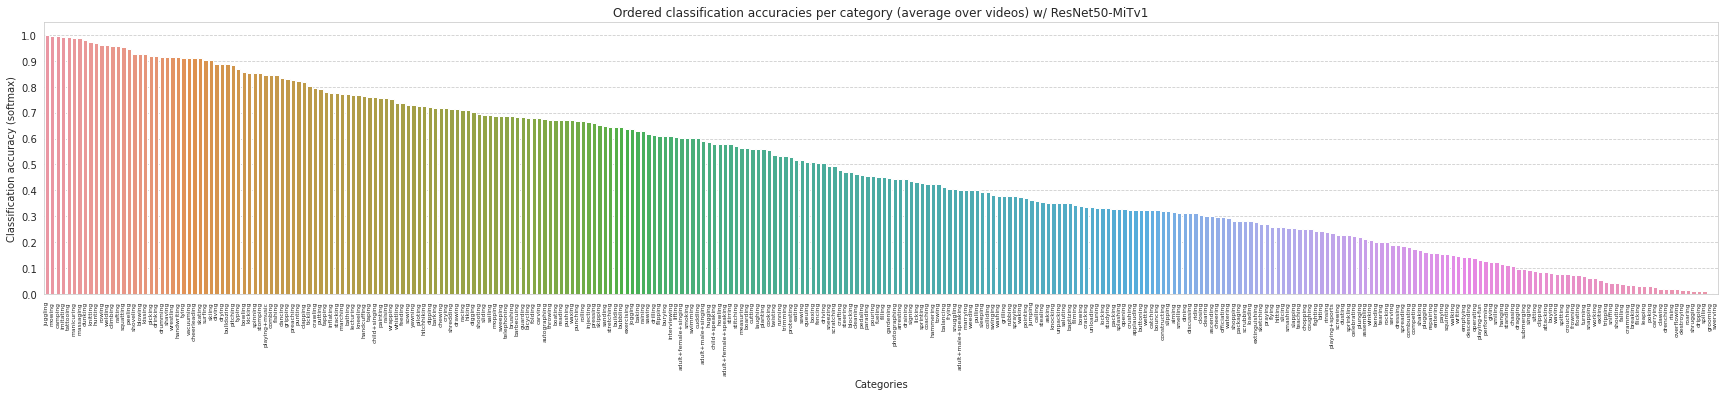

In [24]:
from matplotlib import rc
import matplotlib.ticker as ticker
rc('text', usetex=False) # change to True, if TeX is installed

sns.set_style("whitegrid", {'grid.linestyle': '--'})

plt.figure(figsize=(30, 5))
ax = sns.barplot(x = 'labels', y = 'accuracies',
                 data=acc_df)

plt.xticks(rotation=90, size=6)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_title(f'Ordered classification accuracies per category (average over videos) w/ ResNet50-MiTv1')
ax.set_xlabel('Categories')
ax.set_ylabel('Classification accuracy (softmax)')
#plt.savefig('ordered_accuracies_RN50_MiTv1.pdf')
plt.show()

In [25]:
acc_df

,labels,accuracies
137,juggling,0.998021
157,mowing,0.997152
38,camping,0.995708
132,imitating,0.993401
273,tattooing,0.993025
...,...,...
224,shrugging,0.013996
89,dripping,0.012711
246,spilling,0.011955
120,grooming,0.005347


###### Best vs. Worst frame

In [35]:
# Imports
from decord import VideoReader
from decord import cpu #, gpu
import decord
decord.bridge.set_bridge('native') # Seems to be the fastest option

In [74]:
c_name = 'jogging' # because it's loadead in repo
f_name = 'yt-mKCXk3Gu-eg_74.mp4'

x = np.array(accuracies_per_category[c_name][f_name])
x = x.reshape((len(x, )))
print(x)
print(f'{video_fname} : Max/Min accuracy at frame:' \
        f' {np.argmax(per_frame_accuracies)}/{np.argmin(per_frame_accuracies)}' \
        f' with value: {per_frame_accuracies[np.argmax(per_frame_accuracies)]}' \
        f' / {per_frame_accuracies[np.argmin(per_frame_accuracies)]}')

[4.10039425e-01 4.05268818e-01 5.92250586e-01 6.92182422e-01
 6.27388060e-01 7.36008227e-01 4.14259851e-01 2.79176593e-01
 3.28078181e-01 2.34305143e-01 2.08362147e-01 2.45188653e-01
 1.10399924e-01 1.93750411e-01 3.11379075e-01 4.06747967e-01
 4.51297611e-01 6.78090215e-01 5.06696284e-01 4.02434856e-01
 4.79527563e-01 5.04186094e-01 4.09741074e-01 6.22538447e-01
 5.59054613e-01 5.50690532e-01 3.97706181e-01 6.46479070e-01
 6.05656922e-01 3.89011234e-01 4.88920301e-01 6.74727380e-01
 7.52416134e-01 8.16826761e-01 7.73249686e-01 7.29387581e-01
 9.23861384e-01 8.23402166e-01 8.71479332e-01 9.41486478e-01
 9.54864085e-01 8.92362833e-01 8.71649563e-01 7.97542036e-01
 8.67833078e-01 8.57596695e-01 8.91346872e-01 8.93378913e-01
 8.17198098e-01 6.16332650e-01 2.87666827e-01 1.82626262e-01
 4.13604915e-01 6.68448925e-01 6.20184779e-01 3.18852603e-01
 1.72402710e-02 1.21323916e-03 1.19093060e-03 1.04331493e-03
 1.17093883e-03 1.28903217e-03 1.47432706e-03 1.65401539e-03
 1.57351466e-03 1.543432

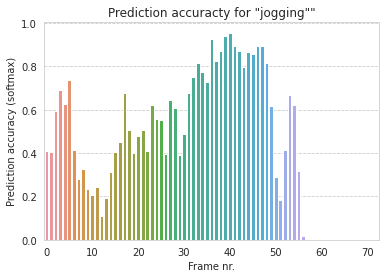

In [75]:
import seaborn as sns
ax = sns.barplot(data=accuracies_per_category[c_name][f_name])
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_title(f'Prediction accuracty for \"{c_name}\""')
ax.set_xlabel('Frame nr.')
ax.set_ylabel('Prediction accuracy (softmax)')

plt.show()

In [76]:
# Load file
path_2_file = path_prefix / f'data/MIT_sampleVideos_RAW/{c_name}/{f_name}'
vr = VideoReader(str(path_2_file))

In [77]:
# Load best and worst frames
best_idx  = best_frame_dict[c_name][f_name][0]
worst_idx = worst_frame_dict[c_name][f_name][0]

best_frame = vr.get_batch([best_idx])
worst_frame = vr.get_batch([worst_idx])

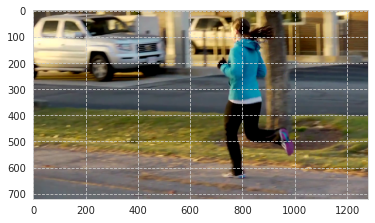

In [78]:
plt.imshow(best_frame.asnumpy()[0])
plt.show()

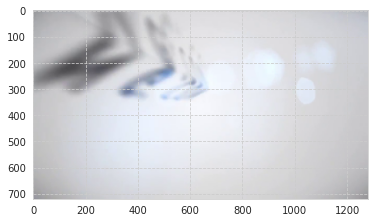

In [79]:
plt.imshow(worst_frame.asnumpy()[0])
plt.show()

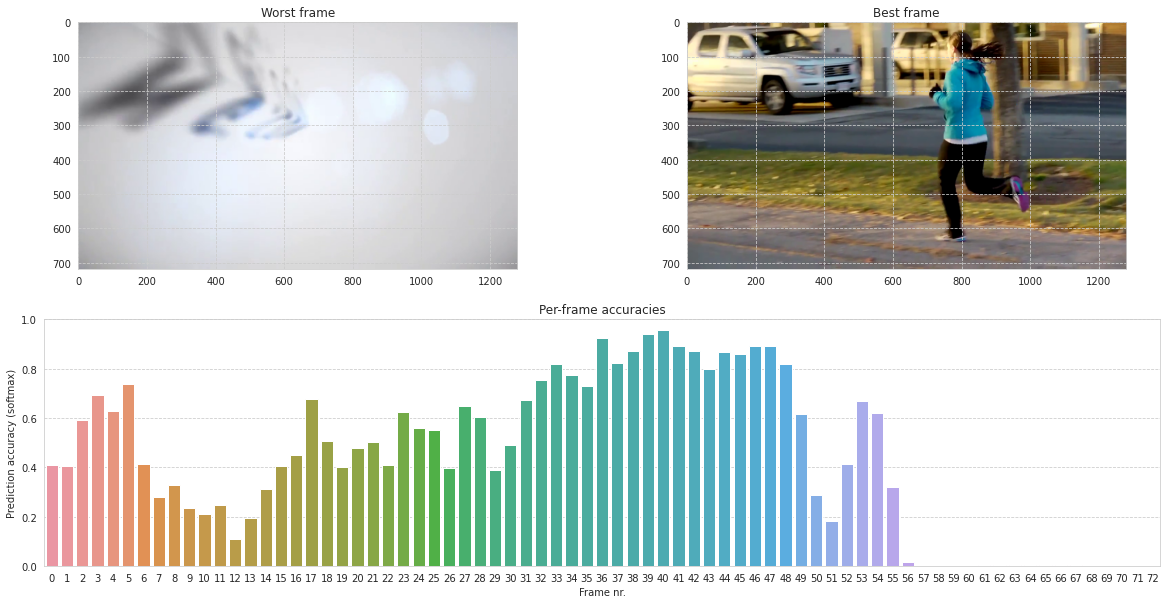

In [82]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})

plt.figure(figsize=(20, 10))

ax1 = plt.subplot(212)
#ax1.margins(0.05)          
ax1 = sns.barplot(data=accuracies_per_category[c_name][f_name])
ax1.set_title('Per-frame accuracies')
ax1.set_xlabel('Frame nr.')
ax1.set_ylabel('Prediction accuracy (softmax)')


ax2 = plt.subplot(221)
#ax2.margins(2, 2)           
ax2.imshow(worst_frame.asnumpy()[0])
ax2.set_title('Worst frame')

ax3 = plt.subplot(222)
#ax3.margins(x=0, y=-0.25)  
ax3.imshow(best_frame.asnumpy()[0])
ax3.set_title('Best frame')

plt.show()